# Dissertation Progress Presentation: Demonstration 19 February 2018

This document demonstrates the following:
* Demonstration of the libraries created for my dissertation
* Some spatial optimization implementations
* Some spatial analyses motivating future work

# Contents
* [Imports](#Imports)
* [Data Setup](#Data-Setup)
* [Create AOI and Parameters](#Create-AOI-and-Parameters)
* [Airfield Objective](#Airfield-Objective)
 * [Site Suitability](#Site-Suitability)
 * [Site Configuration](#Site-Configuration)
 * [Site Evaluation](#Site-Evaluation)
* [Camp 1 Objective](#Camp-1-Objective)
* [Camp 2 Objective](#Camp-2-Objective)
* [Site Relations](#Site-Relations)

# Imports

In [1]:
import SpatialIO as io
import FirstPass as firstpass
import pgdissroute as pgdissroute
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import numpy as np
import random
%matplotlib inline
pd.options.display.max_columns = 200
reload(pgdissroute)
reload(firstpass)
reload(io)

<module 'SpatialIO' from 'SpatialIO.pyc'>

# Data Setup

In [2]:
slopePath = '../FLW_Missouri Mission Folder/RASTER/slope_proj.tif'
elevationPath = "../FLW_Missouri Mission Folder/RASTER/DEM_CMB_ELV_SRTMVF2_proj.tif"
vector_path = './test_data/UtilityInfrastructureCrv_3.shp'
roadsPath = './test_data/tgc.shp'
landcoverPath = '../FLW_Missouri Mission Folder/RASTER/LC_LandCover_GeoCover_proj.tif'

# Create AOI and Parameters

Text(0.5,0.98,u'Areas of Interest')

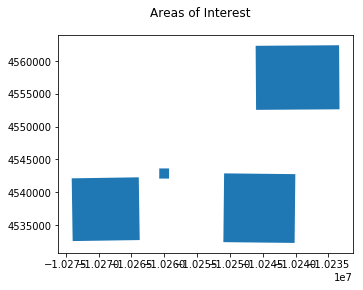

In [3]:
aoiDF = gpd.read_file("../FLW_Missouri Mission Folder/SUPPORT/Staging.shp")
aoiDF = aoiDF.to_crs({'init':'epsg:3857'})
squareDimension = 400
aoiDF.plot()
plt.suptitle("Areas of Interest")

# Airfield Objective

## Site Suitability

In [4]:
airfieldAOI = aoiDF[aoiDF['Stage']=='Gold'].reset_index().geometry[0]
airfieldEvaluationDataFrame = firstpass.generateEvaluationGridDataFrame(airfieldAOI,100)

Generated 12161 squares in 0 seconds


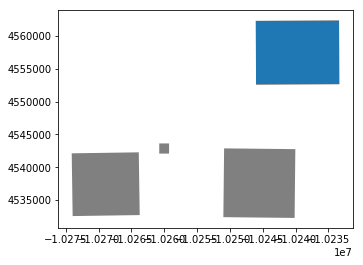

In [5]:
airfieldEvaluationDataFrame.plot(ax=aoiDF.plot(color='grey'))

In [6]:
airfieldSlopeEvaluationDataFrame = firstpass.generateRasterStatisticsForDataFrame(airfieldEvaluationDataFrame,slopePath,stats="mean max",isCategorical=False)


/home/noah/anaconda2/lib/python2.7/site-packages/rasterstats/main.py:142: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
/home/noah/anaconda2/lib/python2.7/site-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)


Text(0.5,0.98,u'Zonal Calculation of Maximum Slope over AOI')

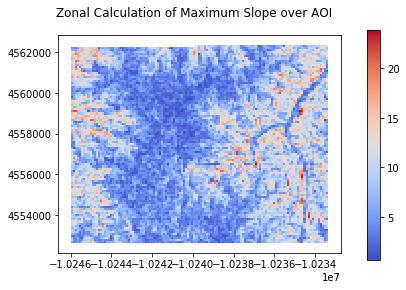

In [7]:
vmin = min(airfieldSlopeEvaluationDataFrame['max'])
vmax = max(airfieldSlopeEvaluationDataFrame['max'])
ax = airfieldSlopeEvaluationDataFrame.plot(column='max', cmap='coolwarm', vmin=vmin, vmax=vmax)
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.suptitle("Zonal Calculation of Maximum Slope over AOI")

Text(0,0.5,u'Fraction of AOI Evaluation Grid')

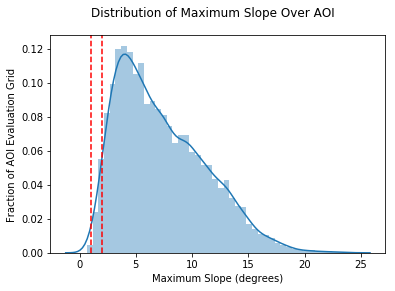

In [8]:
sns.distplot(airfieldSlopeEvaluationDataFrame['max'])
plt.axvline(1, color='red', linestyle='--')
plt.axvline(2, color='red', linestyle='--')
plt.suptitle("Distribution of Maximum Slope Over AOI")
plt.xlabel("Maximum Slope (degrees)")
plt.ylabel("Fraction of AOI Evaluation Grid")

**Subset by maximum slope < 2**

In [9]:
airfieldSlopeEvaluationDataFrameSubset = airfieldSlopeEvaluationDataFrame[airfieldSlopeEvaluationDataFrame['max'] < 2]
print "Subset consists of %s areas, reduced from the original %s areas" %(len(airfieldSlopeEvaluationDataFrameSubset.index),len(airfieldSlopeEvaluationDataFrame.index))

Subset consists of 364 areas, reduced from the original 12161 areas


Text(0.5,0.98,u'New Evaluation Areas')

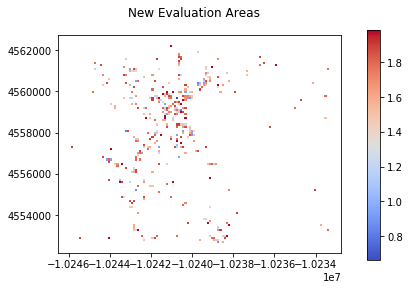

In [10]:
vmin = min(airfieldSlopeEvaluationDataFrameSubset['max'])
vmax = max(airfieldSlopeEvaluationDataFrameSubset['max'])
ax = airfieldSlopeEvaluationDataFrameSubset.plot(column='max', cmap='coolwarm', vmin=vmin, vmax=vmax)
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.suptitle("New Evaluation Areas")

**Create Larger Candidate Sites Using the Simplified Approach**

**Distance to Linear Features**

In [11]:
roadsDF = gpd.read_file(roadsPath)
roadsDF.crs = {'init':'epsg:3857'}
roadsDF = roadsDF.to_crs({'init':'epsg:3857'})

In [12]:
lx,ly,ux,uy = airfieldEvaluationDataFrame.total_bounds
bufferDistance = 1000
lx -= bufferDistance
ly += bufferDistance
ux -= bufferDistance
uy += bufferDistance
roadsDF = firstpass.filterDataFrameByBounds(roadsDF,lx,ly,ux,uy)

Text(0.5,0.98,u'Roads Near the AOI')

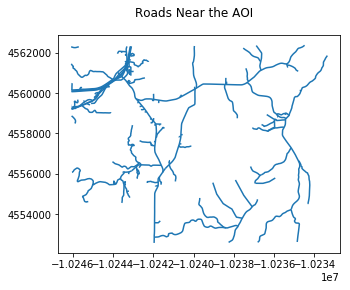

In [ ]:
roadsDF.plot()
plt.suptitle("Roads Near the AOI")

In [ ]:
airfieldEvaluationDataFrame = firstpass.minimumDistanceFromEvaluationToDataFrameFeatures(airfieldEvaluationDataFrame,roadsDF)

In [ ]:
vmin = min(airfieldEvaluationDataFrame['distance'])
vmax = max(airfieldEvaluationDataFrame['distance'])
ax = airfieldEvaluationDataFrame.plot(column='distance', cmap='coolwarm', vmin=vmin, vmax=vmax, ax=roadsDF.plot(color='white'))
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
fig.suptitle("Distance of each site from nearest MSR")

In [ ]:
sns.distplot(airfieldEvaluationDataFrame['distance'])
plt.axvline(400, color='red', linestyle='--')
plt.axvline(800, color='red', linestyle='--')
plt.suptitle("Distribution of Road Distance From Candidate Sites")
plt.xlabel("Road Distance (m)")
plt.ylabel("Fraction of Candidate Sites")

## Site Configuration

In [ ]:
largerPolygonDimension = 800
largerAirfields = firstpass.convertSubsettedEvaluationDFIntoPolygonGrid(airfieldSlopeEvaluationDataFrameSubset, largerPolygonDimension)

In [ ]:
largerAirfields.plot()
plt.suptitle("Site Configuration for Airfield")

## Site Evaluation

**Calculate Cut Fill For Objective Function**

In [ ]:
cutFillDF = firstpass.calculateCutFill(largerAirfields,elevationPath,finalElevation='mean',rasterResolution=1)

In [ ]:
vmin = min(cutFillDF['totalCutFillVolume'])
vmax = max(cutFillDF['totalCutFillVolume'])
ax = cutFillDF.plot(column='totalCutFillVolume', cmap='coolwarm', vmin=vmin, vmax=vmax)

# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
fig.suptitle("Cut Fill Required for Candidate Airfields (m^3)")

In [ ]:
sns.distplot(cutFillDF['totalCutFillVolume'])
plt.axvline(0, color='red', linestyle='--')
plt.axvline(2000, color='red', linestyle='--')
plt.suptitle("Distribution of Horizontal Engineering Required For Candidate Sites")
plt.xlabel("Horizontal Engineering (m^3)")
plt.ylabel("Fraction of Candidate Sites")

# Camp 1 Objective

In [ ]:
baseObjective1AOI = aoiDF[aoiDF['Stage']=='Red'].reset_index().geometry[0]
baseObjective1EvaluationDataFrame = firstpass.generateEvaluationGridDataFrame(baseObjective1AOI,100)

In [ ]:
baseObjective1EvaluationDataFrame.plot(ax=aoiDF.plot(color='grey'))
plt.suptitle("Context: Location of Site 1")

In [ ]:
site1SlopeEvaluationDataFrame = firstpass.generateRasterStatisticsForDataFrame(baseObjective1EvaluationDataFrame,slopePath,stats="mean max",isCategorical=False)

In [ ]:
vmin = min(site1SlopeEvaluationDataFrame['max'])
vmax = max(site1SlopeEvaluationDataFrame['max'])
ax = site1SlopeEvaluationDataFrame.plot(column='max', cmap='coolwarm', vmin=vmin, vmax=vmax)
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.suptitle("Zonal Calculation of Maximum Slope over AOI")

In [ ]:
roadsDF = gpd.read_file(roadsPath)
roadsDF.crs = {'init':'epsg:3857'}
roadsDF = roadsDF.to_crs({'init':'epsg:3857'})

lx,ly,ux,uy = site1SlopeEvaluationDataFrame.total_bounds
bufferDistance = 1000
lx -= bufferDistance
ly += bufferDistance
ux -= bufferDistance
uy += bufferDistance
roadsDF = firstpass.filterDataFrameByBounds(roadsDF,lx,ly,ux,uy)

site1SlopeEvaluationDataFrame = firstpass.minimumDistanceFromEvaluationToDataFrameFeatures(site1SlopeEvaluationDataFrame,roadsDF)

In [ ]:
vmin = min(site1SlopeEvaluationDataFrame['distance'])
vmax = max(site1SlopeEvaluationDataFrame['distance'])
ax = site1SlopeEvaluationDataFrame.plot(column='distance', cmap='coolwarm', vmin=vmin, vmax=vmax, ax=roadsDF.plot(color='white'))
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
fig.suptitle("Distance of each site from nearest MSR")

# Camp 2 Objective

In [ ]:
baseObjective2AOI = aoiDF[aoiDF['Stage']=='Blue'].reset_index().geometry[0]
baseObjective2EvaluationDataFrame = firstpass.generateEvaluationGridDataFrame(baseObjective2AOI,100)

In [ ]:
baseObjective2EvaluationDataFrame.plot(ax=aoiDF.plot(color='grey'))
plt.suptitle("Context: Location of Site 2")

In [ ]:
site2SlopeEvaluationDataFrame = firstpass.generateRasterStatisticsForDataFrame(baseObjective2EvaluationDataFrame,slopePath,stats="mean max",isCategorical=False)

In [ ]:
vmin = min(site2SlopeEvaluationDataFrame['max'])
vmax = max(site2SlopeEvaluationDataFrame['max'])
ax = site2SlopeEvaluationDataFrame.plot(column='max', cmap='coolwarm', vmin=vmin, vmax=vmax)
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
plt.suptitle("Zonal Calculation of Maximum Slope over AOI")

In [ ]:
roadsDF = gpd.read_file(roadsPath)
roadsDF.crs = {'init':'epsg:3857'}
roadsDF = roadsDF.to_crs({'init':'epsg:3857'})

lx,ly,ux,uy = site2SlopeEvaluationDataFrame.total_bounds
bufferDistance = 1000
lx -= bufferDistance
ly += bufferDistance
ux -= bufferDistance
uy += bufferDistance
roadsDF = firstpass.filterDataFrameByBounds(roadsDF,lx,ly,ux,uy)

site2SlopeEvaluationDataFrame = firstpass.minimumDistanceFromEvaluationToDataFrameFeatures(site2SlopeEvaluationDataFrame,roadsDF)

In [ ]:
vmin = min(site2SlopeEvaluationDataFrame['distance'])
vmax = max(site2SlopeEvaluationDataFrame['distance'])
ax = site2SlopeEvaluationDataFrame.plot(column='distance', cmap='coolwarm', vmin=vmin, vmax=vmax, ax=roadsDF.plot(color='white'))
# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)
fig.suptitle("Distance of each site from nearest MSR")

# Site Relations

**Set Up Three Candidate Solution DataFrames**

In [ ]:
airfieldCandidates = cutFillDF[cutFillDF['totalCutFillVolume'] < 2000]
print "Evaluating %s candidates for the airfield site" %(len(airfieldCandidates.index))

In [ ]:
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['distance'] > 400]
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['distance'] < 800]
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['mean'] > 2]
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['mean'] < 5]
randomIndexes = np.random.randint(0,len(site1Candidates.index),100)
site1Candidates = site1Candidates.iloc[randomIndexes,:]
largerPolygonDimension = 400
site1Candidates = firstpass.convertSubsettedEvaluationDFIntoPolygonGrid(site1Candidates, largerPolygonDimension)
print "Evaluating %s candidates for the Site 1" %(len(site1Candidates.index))

In [ ]:
site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['distance'] > 400]
site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['distance'] < 800]
site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['mean'] > 2]
site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['mean'] < 5]
randomIndexes = np.random.randint(0,len(site2Candidates.index),100)
site2Candidates = site2Candidates.iloc[randomIndexes,:]
largerPolygonDimension = 400
site2Candidates = firstpass.convertSubsettedEvaluationDFIntoPolygonGrid(site2Candidates, largerPolygonDimension)
print "Evaluating %s candidates for the Site 1" %(len(site2Candidates.index))

In [ ]:
airfieldCandidates.plot(color='gold',ax=site1Candidates.plot(color='red',ax=site2Candidates.plot(color='blue')))
plt.suptitle("Candidate Sites for Relational Analysis")

In [224]:
class CandidateSolution:
    def __init__(self,geom1,geom2,geom3):
        self.geom1 = geom1
        self.geom2 = geom2
        self.geom3 = geom3

In [ ]:
# generate solutionDF at random
geomDF = site1Candidates
geomDF.crs = {'init':'EPSG:3857'}
geomDF = geomDF.to_crs({'init':'EPSG:4326'})
heat_data1 = []
for gen in range(0,10):
    generation = []
    for ind in range(0,10):
        randomIndex = np.random.randint(0,len(geomDF.index))
        randomCandidate = geomDF.iloc[randomIndex,:].geometry
        randomCandidateCentroid = randomCandidate.centroid
        generation.append([randomCandidateCentroid.y,randomCandidateCentroid.x])
    heat_data1.append(generation)
        

In [ ]:
geom2DF = site2Candidates
geom2DF.crs = {'init':'EPSG:3857'}
geom2DF = geom2DF.to_crs({'init':'EPSG:4326'})
heat_data2 = []
for gen in range(0,10):
    generation = []
    for ind in range(0,10):
        randomIndex = np.random.randint(0,len(geom2DF.index))
        randomCandidate = geom2DF.iloc[randomIndex,:].geometry
        randomCandidateCentroid = randomCandidate.centroid
        generation.append([randomCandidateCentroid.y,randomCandidateCentroid.x])
    heat_data2.append(generation)

In [ ]:
airfieldDF = airfieldCandidates
airfieldDF.crs = {'init':'EPSG:3857'}
airfieldDF = airfieldDF.to_crs({'init':'EPSG:4326'})
heat_data3 = []
for gen in range(0,10):
    generation = []
    for ind in range(0,10):
        randomIndex = np.random.randint(0,len(geom2DF.index))
        randomCandidate = airfieldDF.iloc[randomIndex,:].geometry
        randomCandidateCentroid = randomCandidate.centroid
        generation.append([randomCandidateCentroid.y,randomCandidateCentroid.x])
    heat_data3.append(generation)

In [298]:
m = io.Map()
# merge the data
merged_heat_data = []
i = 0
for gen in heat_data1:
    gen.extend(heat_data2[i])
    gen.extend(heat_data3[i])
    merged_heat_data.append(gen)
    i += 1
m.addTimeSeriesHeatMapFromArray(merged_heat_data)

In [299]:
m.map

In [ ]:
class individual:
    def __init__self()

# Notes for Future Work

**Epistasis by Index**

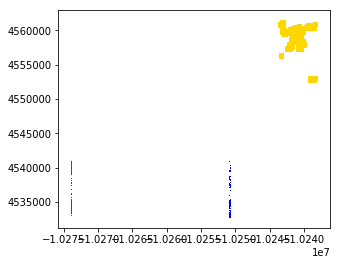

In [116]:
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['distance'] > 400]
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['distance'] < 800]
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['mean'] > 2]
site1Candidates = site1SlopeEvaluationDataFrame[site1SlopeEvaluationDataFrame['mean'] < 5]
site1Candidates = site1Candidates[0:100]

site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['distance'] > 400]
site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['distance'] < 800]
site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['mean'] > 2]
site2Candidates = site2SlopeEvaluationDataFrame[site2SlopeEvaluationDataFrame['mean'] < 5]
site2Candidates = site2Candidates[0:100]

airfieldCandidates.plot(color='gold',ax=site1Candidates.plot(color='red',ax=site2Candidates.plot(color='blue')))

Text(0.5,0.98,u'Demonstration of Epistasis: Candidate Sites by Index')

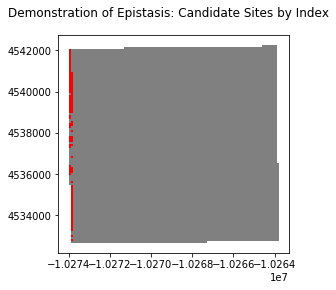

In [123]:
site1Candidates.plot(color='red',ax=site1SlopeEvaluationDataFrame.plot(color='grey'))
plt.suptitle("Demonstration of Epistasis: Candidate Sites by Index")

In [313]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

In [325]:
weights=(-1.0,-1.0)
creator.create("FitnessMin", base.Fitness, weights=weights)
creator.create("Individual", list, fitness=creator.FitnessMin)

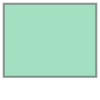

In [361]:
airfieldCandidate = airfieldDF
airfieldCandidate.crs = {'init':'EPSG:3857'}
airfieldCandidate = airfieldCandidate.to_crs({'init':'EPSG:4326'})
airfieldCandidate = airfieldCandidate.iloc[2,:]
airfieldCandidate['geometry']
#airfieldCentroidLon = float(airfieldCandidate[0:1]['geometry'].centroid.x)
#airfieldCentroidLat = float(airfieldCandidate[0:1]['geometry'].centroid.y)

In [373]:
def evaluate(individual):
    # retreive geometries
    airfieldCandidate = airfieldDF
    airfieldCandidate.crs = {'init':'EPSG:3857'}
    airfieldCandidate = airfieldCandidate.to_crs({'init':'EPSG:4326'})
    airfieldCandidate = airfieldDF.iloc[individual[0],:]
    airfieldCentroidLon = float(airfieldCandidate['geometry'].centroid.x)
    airfieldCentroidLat = float(airfieldCandidate['geometry'].centroid.y)
    
    redCandidate = geomDF
    redCandidate.crs = {'init':'EPSG:3857'}
    redCandidate = redCandidate.to_crs({'init':'EPSG:4326'})
    redCandidate = geomDF.iloc[individual[1],:]
    redCentroidLon = float(redCandidate['geometry'].centroid.x)
    redCentroidLat = float(redCandidate['geometry'].centroid.y)
    
    blueCandidate = geom2DF
    blueCandidate.crs = {'init':'EPSG:3857'}
    blueCandidate = blueCandidate.to_crs({'init':'EPSG:4326'})
    blueCandidate = geom2DF.iloc[individual[2],:]
    blueCentroidLon = float(blueCandidate['geometry'].centroid.x)
    blueCentroidLat = float(blueCandidate['geometry'].centroid.y)
    
    # distance from airfield to site red
    redToAirfieldDistance = pgdissroute.calculateRouteDistance(airfieldCentroidLon,airfieldCentroidLat,redCentroidLon,redCentroidLat)
    # distance from airfield to site blue
    blueToAirfieldDistance = pgdissroute.calculateRouteDistance(airfieldCentroidLon,airfieldCentroidLat,blueCentroidLon,blueCentroidLat)
    
    # print for debugging
    print "red is %s m from airfield, at (%s,%s)" %(redToAirfieldDistance,redCentroidLon,redCentroidLat)
    print "blue is %s m from airfield, at (%s,%s)" %(blueToAirfieldDistance,blueCentroidLon,blueCentroidLat)
    
    return redToAirfieldDistance, blueToAirfieldDistance

def mutate(individual,propElementMutation=0.1):
    attrDictionary = {0: (0, len(airfieldCandidates.index)),
                  1: (0,len(geomDF.index)),
                      2: (0,len(geom2DF.index))}# nopep8
    for i in range(0,len(individual)):
        attr = individual[i]
        shouldWeMutate = np.random.random() <= probElementMutation
        if shouldWeMutate:
            newAttrLowerBound = attrDictionary[i][0]
            newAttrUpperBound = attrDictionary[i][1]
            newAttrValue = np.random.randint(newAttrLowerBound,newAttrUpperBound)
            individual[i] = newAttrValue
    return (individual,)

def createPopulation(populationSize):
    toolbox.register("index1",random.randint,0,len(airfieldCandidates.index))
    toolbox.register("index2",random.randint,0,len(geomDF.index))
    toolbox.register("index3",random.randint,0,len(geom2DF.index))
    genes = [toolbox.index1,toolbox.index2,toolbox.index3]
    toolbox.register("individual", tools.initCycle, creator.Individual,
                     genes, n=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    population = toolbox.population(n=populationSize)
    return population

In [376]:
toolbox = base.Toolbox()
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", mutate)
toolbox.register("select", tools.selNSGA2)
population = createPopulation(3)
print population
hallOfFame = tools.ParetoFront()  
logbook = tools.Logbook()

[[30, 27, 81], [62, 88, 84], [102, 98, 46]]


In [384]:
# perform the GA
stats = tools.Statistics(key= lambda ind: individual.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
for individual in population:
    individual.fitness.values = toolbox.evaluate(individual)
record = stats.compile(population)
hallOfFame.update(population)

pMutation = 0.1
pCrossover = 0.5

maxElite = 1

red is 36662.5966431 m from airfield, at (-92.2277550544,37.6819982797)
blue is 23032.851855 m from airfield, at (-92.0669155487,37.7205103659)
red is 39615.2720141 m from airfield, at (-92.2789590256,37.7019019497)
blue is 26606.4682605 m from airfield, at (-92.0049317941,37.6679094159)
red is 33390.2010357 m from airfield, at (-92.2079921182,37.7218002769)
blue is 22928.9214642 m from airfield, at (-92.0812885932,37.7304576989)
GENERATION 0


TypeError: 'Map' object is not callable

In [ ]:
for generation in range(0,3):
    print "GENERATION %s" %(generation)
    theBestIndividuals = []
    if len(hallOfFame.items) <= maxElite:
        theBestIndividuals = hallOfFame.items
    elif len(hallOfFame.items) > 0:
        theBestIndividuals = hallOfFame.items[0:maxElite]
    reducedOffspring = toolbox.select(population, len(population)-len(theBestIndividuals))
    offspring = theBestIndividuals + reducedOffspring   
   # Clone the selected individuals
    offspring = map(toolbox.clone, offspring)

    # Apply crossover on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() <= pCrossover:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    # Apply mutation on the offspring, with a probability assigned to each gene  # nopep8
    for mutant in offspring:
        toolbox.mutate(mutant, pMutation)
        del mutant.fitness.values
        
    # The population is entirely replaced by the offspring
    population[:] = offspring
    hallOfFame.update(population)
    record=stats.compile(population)
    
    for individual in population: 
        allScores.append(individual.fitness.values)
            
    logbook.record(gen=generation, allIndividuals = list(population), allScores = allScores, top5 = theBestIndividuals[0], bestScore = theBestIndividuals[0].fitness.values,
                       **record)
    print theBestIndividuals[0], theBestIndividuals[0].fitness.values

In [382]:
for individual in population:
    print individual.fitness.values

(36662.596643098106, 23032.851854983102)
(39615.272014086797, 26606.468260459045)
(33390.201035655249, 22928.921464170384)


In [383]:
record

{'avg': 28159.561249912818,
 'max': 33390.201035655249,
 'min': 22928.921464170384,
 'std': 5230.6397857424317}

**Routing**

In [ ]:
reload(pgdissroute)

In [185]:
site1Candidates.crs = {"init":"EPSG:3857"}
site1Candidates_Projected = site1Candidates.to_crs({"init":"EPSG:4326"})

site2Candidates.crs = {"init":"EPSG:3857"}
site2Candidates_Projected = site2Candidates.to_crs({"init":"EPSG:4326"})

startLon = float(site1Candidates_Projected[0:1]['geometry'].centroid.x)
startLat = float(site1Candidates_Projected[0:1]['geometry'].centroid.y)

endLon = float(site2Candidates_Projected[0:1]['geometry'].centroid.x)
endLat = float(site2Candidates_Projected[0:1]['geometry'].centroid.y)

#startLon,startLat,endLon,endLat = -92.068859,37.846720,-92.142373,37.557935
df,m = pgdissroute.route(startLon,startLat,endLon,endLat)

In [186]:
m

In [184]:
sum(df['length_m'])

31218.236738914948